## Dependencias 

In [22]:
import numpy as np 
import pandas as pd 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from functools import reduce 
import seaborn as sns
pd.set_option('display.max_columns',None)

## Lectura de datos 

In [2]:
data = pd.read_clipboard()
print(data.shape)
data.head()

(999, 5)


,x1,x2,x3,x4,y
0,0.719893,0.017431,0.470040,0.334555,0.979378
1,0.083175,0.360228,0.781749,0.391164,1.396295
2,0.958115,0.078518,0.411679,0.224812,1.472067
3,0.824706,0.468581,0.736752,0.006461,1.584797
4,0.845293,0.239755,0.082676,0.963425,1.843452


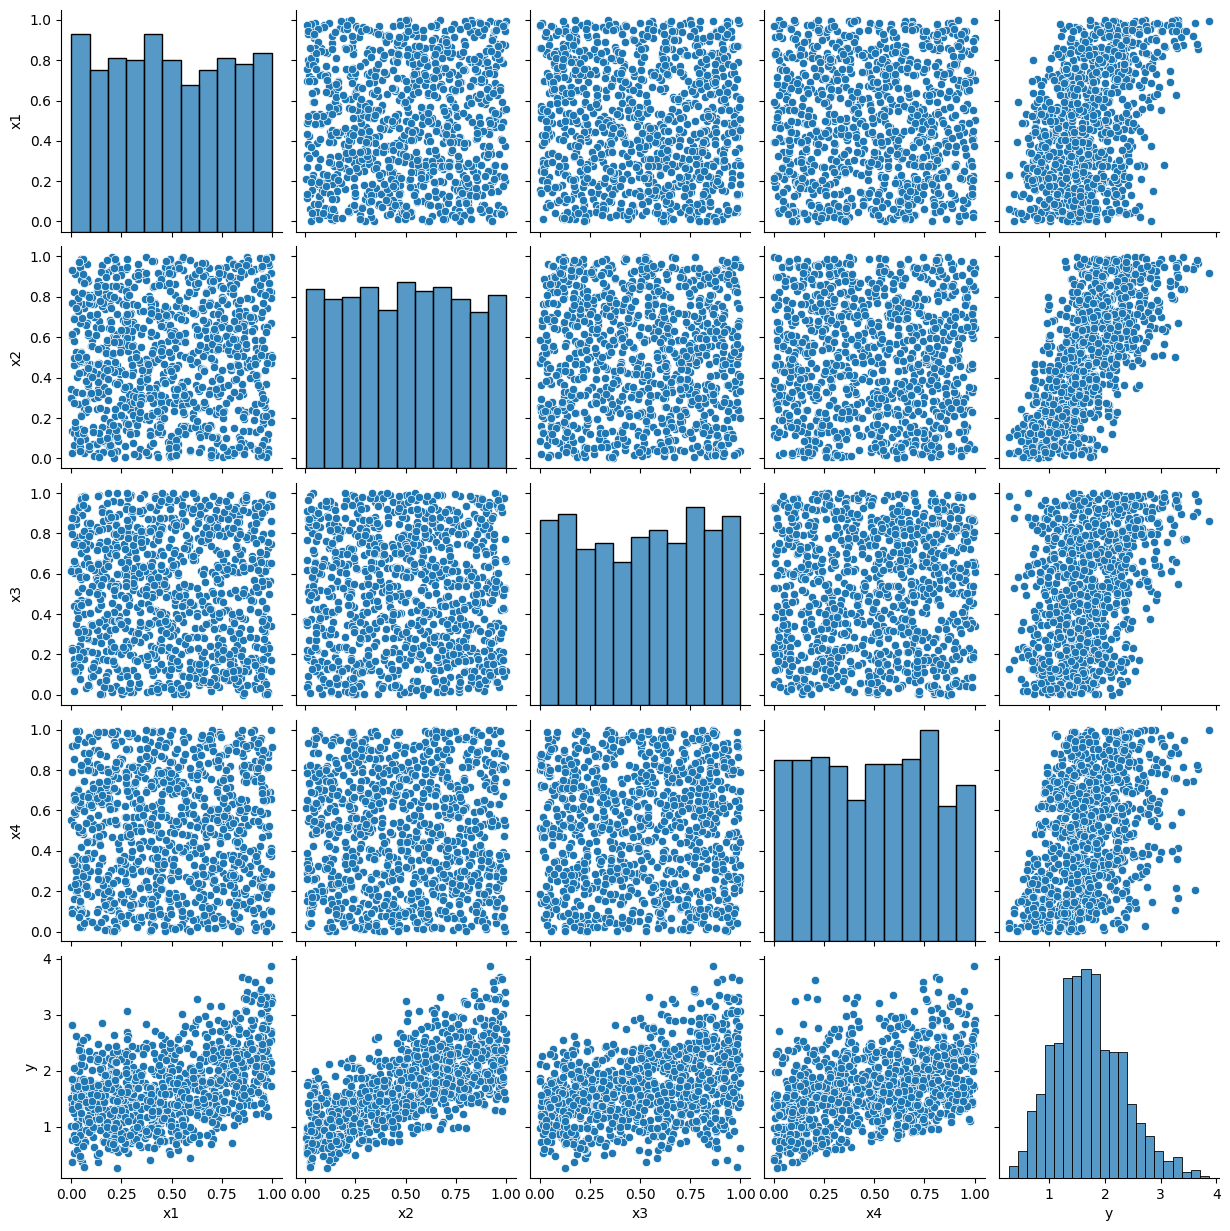

In [5]:
sns.pairplot(data)

## Clasificación de variables 

In [6]:
varc = ['x1','x2','x3','x4']
vart = ['y']

In [8]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')

## Partición 

In [9]:
train,valid = train_test_split(data,test_size=0.2)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((799, 5), (200, 5))

### Matriz de predictoras $\mathcal{X}$

In [10]:
X = train[varc].copy()

### Vector respuesta $\vec{y}$

In [12]:
y = train[vart[0]]
y.head()

0    1.555527
1    0.972328
2    1.854060
3    1.649284
4    1.665930
Name: y, dtype: float64

## Aprendizaje 

In [13]:
var = varc[:]

### Híper-parametrización

In [14]:
hparam_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50,), (100, 50,), (100, 100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': np.logspace(-5, -1, 5),  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 500, 1000]
}


In [15]:
reduce(lambda x,y: x*y, map(len,hparam_grid.values()))

6075

In [16]:
ann = MLPRegressor()

In [25]:
grid = RandomizedSearchCV(
    estimator=ann,
    param_distributions=hparam_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=True,
    cv=5,
    n_iter=50
)

In [26]:
grid.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the 

,estimator,MLPRegressor()
,param_distributions,"{'activation': ['relu', 'tanh', ...], 'alpha': array([1.e-05...e-02, 1.e-01]), 'hidden_layer_sizes': [(50,), (100,), ...], 'learning_rate': ['constant', 'invscaling', ...], ...}"
,n_iter,50
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [27]:
grid.best_score_

np.float64(-0.0002639720950510717)

In [29]:
ann = grid.best_estimator_

### Aprendizaje final $\vec{y} = f (\mathcal{X};\theta)$  (Ahora si vamos a aprender el modelo)

In [30]:
ann.fit(X,y)

,loss,'squared_error'
,hidden_layer_sizes,"(100,)"
,activation,'relu'
,solver,'lbfgs'
,alpha,np.float64(0.0001)
,batch_size,'auto'
,learning_rate,'invscaling'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


#### $\vec{\theta},\theta_0$

In [37]:
[layer.shape for layer in ann.coefs_]

[(4, 100), (100, 1)]

## Generalización del modelo (qué tan bien se comporta en datos que nunca vió, es importante aplicar TODAS las transfromaciones previas)

In [38]:
Xv = valid[varc].copy()


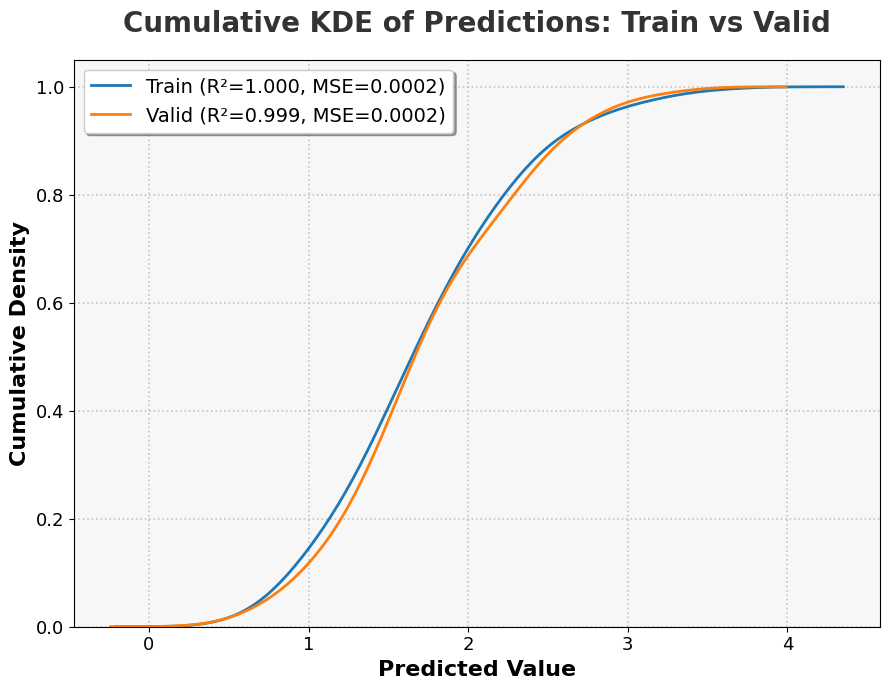

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Training predictions and regression metrics
y_train_pred = ann.predict(X)
mse_train = mean_squared_error(y, y_train_pred)
r2_train = r2_score(y, y_train_pred)

# Validation predictions and regression metrics
y_valid = valid[vart[0]]
y_valid_pred = ann.predict(Xv)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
r2_valid = r2_score(y_valid, y_valid_pred)

plt.figure(figsize=(9, 7))

# KDE cumulative for train and valid predictions
sns.kdeplot(
    y_train_pred, 
    cumulative=True, 
    label=f'Train (R²={r2_train:.3f}, MSE={mse_train:.4f})', 
    color='#1f77b4',
    linewidth=2,
)
sns.kdeplot(
    y_valid_pred, 
    cumulative=True, 
    label=f'Valid (R²={r2_valid:.3f}, MSE={mse_valid:.4f})', 
    color='#ff7f0e',
    linewidth=2,
)
plt.xlabel('Predicted Value', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative Density', fontsize=16, fontweight='bold')
plt.title('Cumulative KDE of Predictions: Train vs Valid', fontsize=20, fontweight='bold', color='#333333', pad=20)
plt.legend(fontsize=14, loc='best', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', linewidth=1.2, alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.show()

## Uso del modelo 

In [42]:

# Create DataFrames for comparing true targets and model predictions for regression
df_train_pred = pd.DataFrame({
    'y_true': y.values,
    'y_pred': ann.predict(X),
    'sample': 'train'
})

df_valid_pred = pd.DataFrame({
    'y_true': y_valid.values,
    'y_pred': ann.predict(Xv),
    'sample': 'valid'
})

# Concatenate train and validation prediction comparisons
df_pred_compare = pd.concat([df_train_pred, df_valid_pred], ignore_index=True)

# Display the first few rows
df_pred_compare.head()



,y_true,y_pred,sample
0,1.555527,1.540959,train
1,0.972328,0.954849,train
2,1.854060,1.825914,train
3,1.649284,1.638066,train
4,1.665930,1.659811,train


In [46]:
df_pred_compare.groupby('sample').describe().T

sample             train       valid
y_true count  799.000000  200.000000
       mean     1.693303    1.724273
       std      0.631719    0.594618
       min      0.269025    0.371195
       25%      1.248380    1.352746
       50%      1.643405    1.650537
       75%      2.079310    2.192233
       max      3.864977    3.355947
y_pred count  799.000000  200.000000
       mean     1.693377    1.725973
       std      0.631433    0.596909
       min      0.285817    0.379063
       25%      1.248336    1.359376
       50%      1.638066    1.655367
       75%      2.084831    2.194561
       max      3.852775    3.371115